In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir='/kaggle/input/egyptian-hieroglyphs/train/'
val_dir='/kaggle/input/egyptian-hieroglyphs/valid/'
test_dir='/kaggle/input/egyptian-hieroglyphs/test/'

train_df=pd.read_csv('/kaggle/input/egyptian-hieroglyphs/train/_annotations.csv')
val_df=pd.read_csv('/kaggle/input/egyptian-hieroglyphs/valid/_annotations.csv')
test_df=pd.read_csv('/kaggle/input/egyptian-hieroglyphs/test/_annotations.csv')

In [3]:
x_train=[]
y_train=[]


files=train_df['filename']

x_min=train_df['xmin']
x_max=train_df['xmax']
y_min=train_df['ymin']
y_max=train_df['ymax']

i=0

for filename in files:
    image=cv2.imread(os.path.join(train_dir,filename))
    cropped_image=image[y_min[i]:y_max[i],x_min[i]:x_max[i]]
    resized_image=cv2.resize(cropped_image,(224,224))
    rgb_image=cv2.cvtColor(resized_image,cv2.COLOR_BGR2RGB)
    x_train.append(rgb_image)
    i+=1

    
y_train=train_df['class']

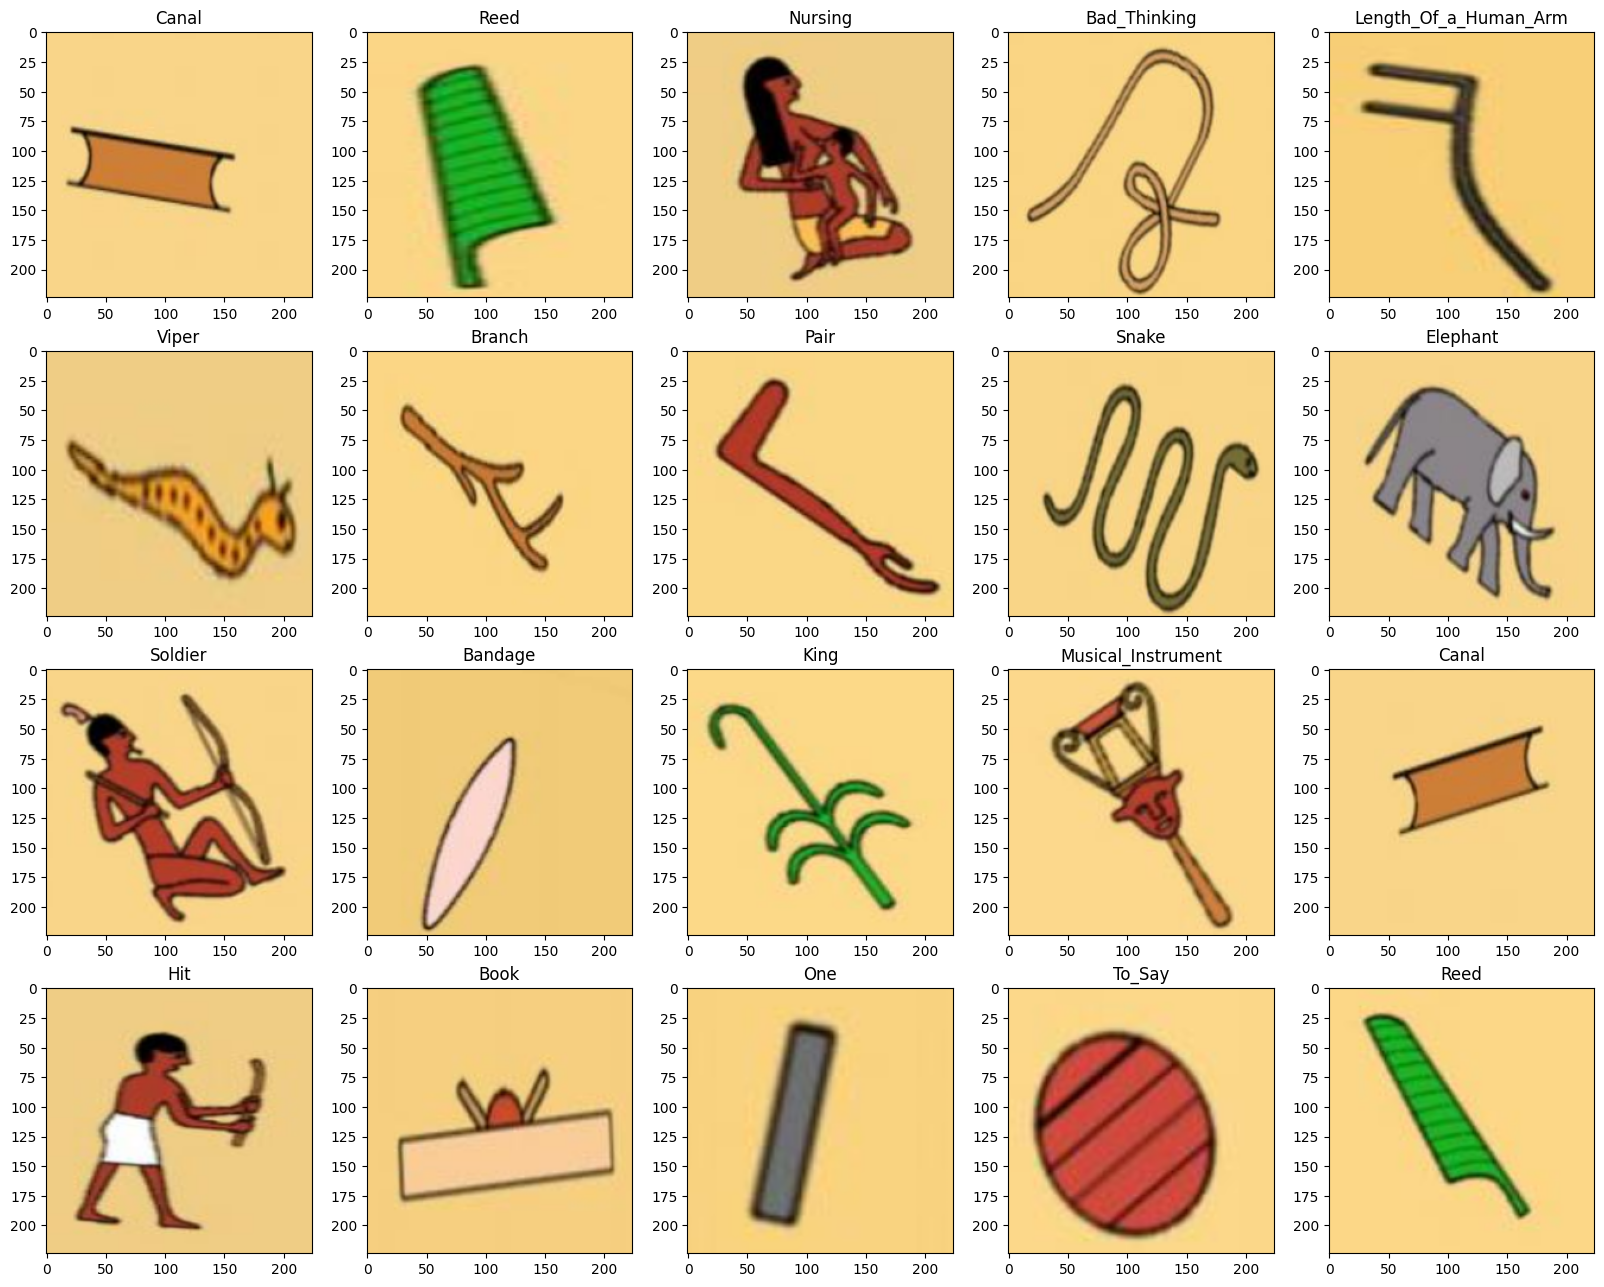

In [4]:
rand_idx=list(np.random.randint(0,len(x_train),20))
plt.figure(figsize=(20,20))
cnt=0
for i in rand_idx:
    plt.subplot(5,5,cnt+1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    cnt+=1

In [5]:
for i in range(len(x_train)):
    x_train[i]=x_train[i]/255.0

In [6]:
x_val=[]
y_val=val_df['class']

files=val_df['filename']

x_min=val_df['xmin']
x_max=val_df['xmax']
y_min=val_df['ymin']
y_max=val_df['ymax']

i=0

for file in files:
    image=cv2.imread(os.path.join(val_dir,file))
    cropped_image=image[y_min[i]:y_max[i],x_min[i]:x_max[i]]
    resized_image=cv2.resize(cropped_image,(224,224))
    rgb_image=cv2.cvtColor(resized_image,cv2.COLOR_BGR2RGB)
    x_val.append(rgb_image)
    i+=1
    

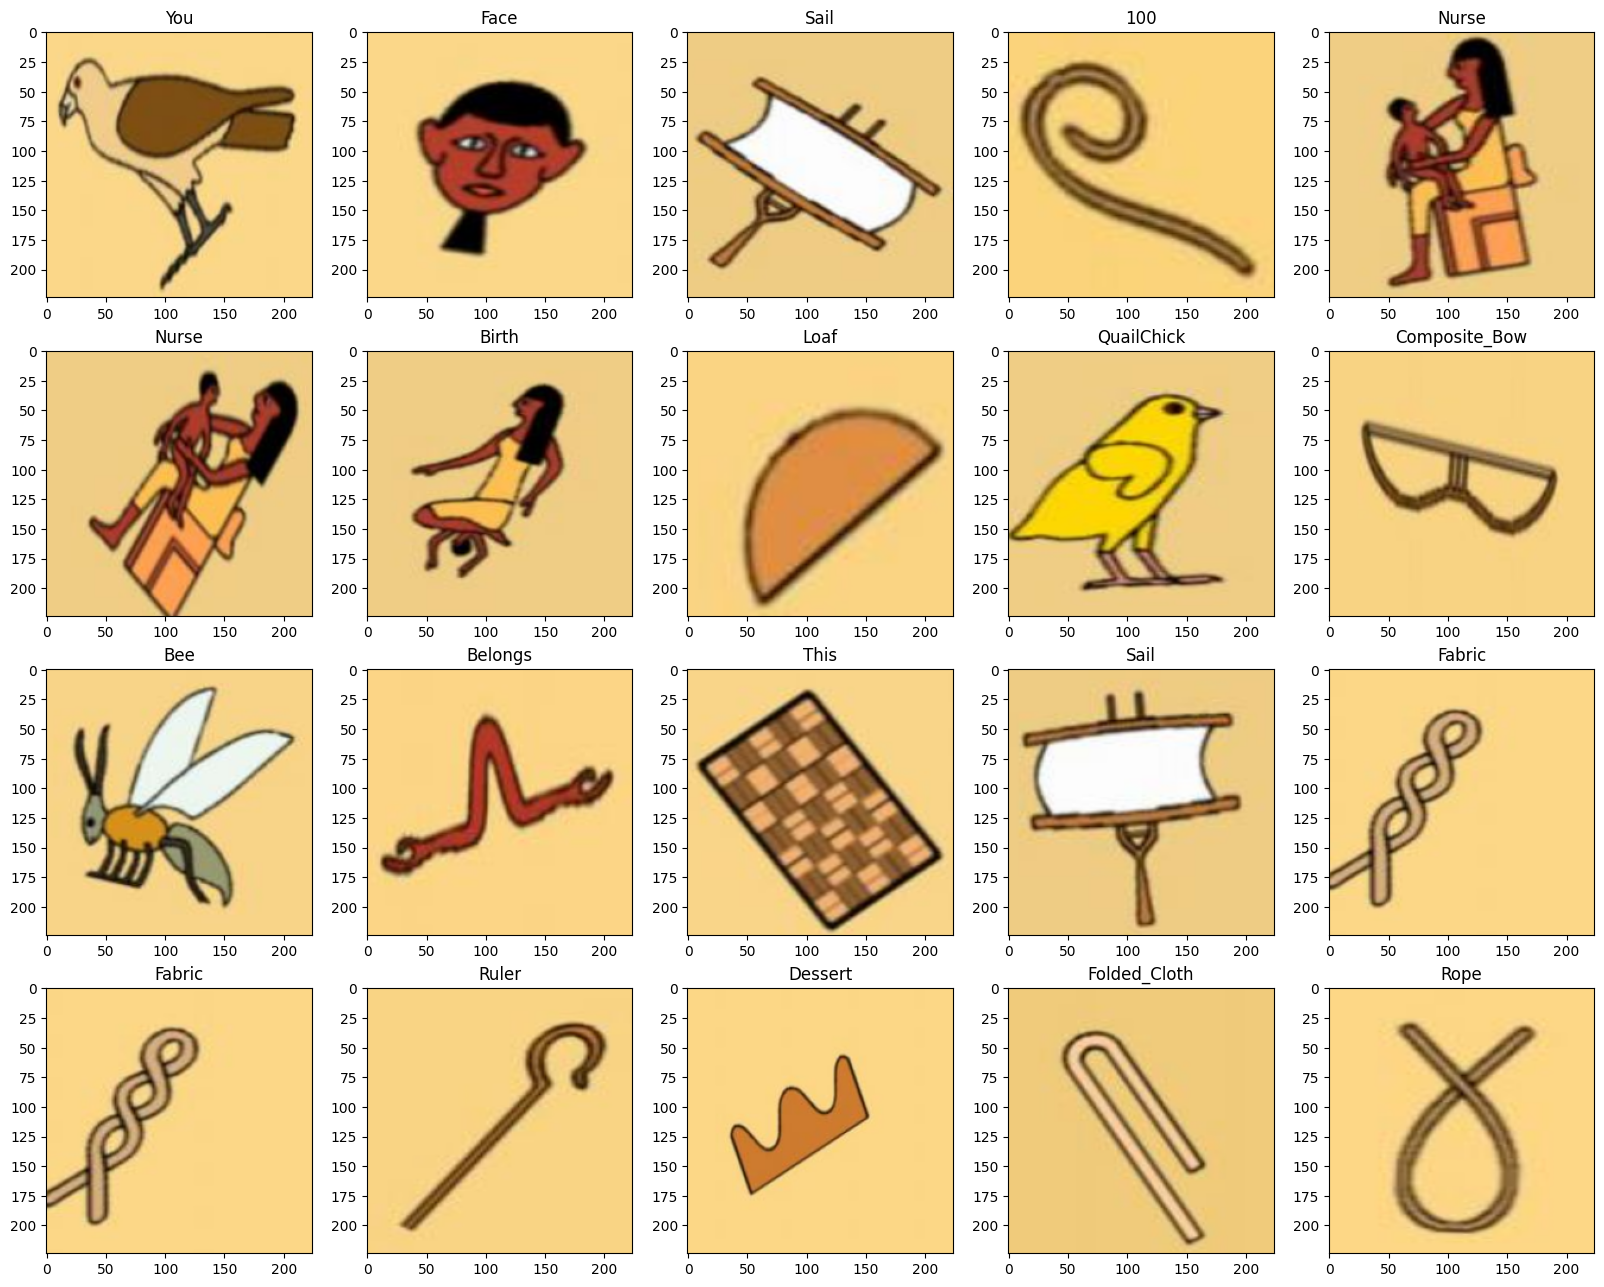

In [7]:
rand_idx=list(np.random.randint(0,len(x_val),20))
plt.figure(figsize=(20,20))
cnt=0
for i in rand_idx:
    plt.subplot(5,5,cnt+1)
    plt.imshow(x_val[i])
    plt.title(y_val[i])
    cnt+=1

In [8]:
for i in range(len(x_val)):
    x_val[i]=x_val[i]/255.0

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

In [10]:
x_train=np.array(x_train)
x_train= x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
y_train=np.array(y_train)
x_val=np.array(x_val)
x_val= x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 3)
y_val=np.array(y_val)

In [11]:
from sklearn.utils import shuffle
x_train,y_train = shuffle(x_train,y_train)

In [12]:
input_shape=(224,224,3)
inputs=tf.keras.Input(shape=input_shape)
base_model_3=tf.keras.applications.NASNetMobile(include_top=False,weights='imagenet',input_tensor=inputs)
base_model_3.trainable=True

var=tf.keras.layers.Flatten()(base_model_3.output)

var=tf.keras.layers.Dense(1025,activation='relu')(var)
var=tf.keras.layers.BatchNormalization()(var)
var=tf.keras.layers.Dropout(0.2)(var)

var=tf.keras.layers.Dense(256,activation='relu')(var)
var=tf.keras.layers.BatchNormalization()(var)
var=tf.keras.layers.Dropout(0.2)(var)

var=tf.keras.layers.Dense(256,activation='relu')(var)
var=tf.keras.layers.BatchNormalization()(var)
var=tf.keras.layers.Dropout(0.2)(var)

var=tf.keras.layers.Dense(256,activation='relu')(var)
var=tf.keras.layers.BatchNormalization()(var)
var=tf.keras.layers.Dropout(0.2)(var)

outputs=tf.keras.layers.Dense(95,activation='softmax')(var)

model_3=tf.keras.models.Model(inputs=inputs,outputs=outputs)

opt=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

model_3.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])



19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

early_stopping=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
learning_rate=ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-6,patience=10)
ckeck_points=ModelCheckpoint(filepath='best_model.keras',monitor='val_loss',save_best_only=True,save_weights_only=False)

In [14]:
history_3=model_3.fit(x_train,y_train,epochs=50,batch_size=32,validation_data=(x_val,y_val),callbacks=[early_stopping,learning_rate,ckeck_points],shuffle=True)

Epoch 1/50


I0000 00:00:1732305482.117991      65 service.cc:145] XLA service 0x7b25e4083600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732305482.118062      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732305617.286081      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.2169 - loss: 3.7326

I0000 00:00:1732305774.404876      66 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 36 bytes spill stores, 36 bytes spill loads



86/86 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.2212 - loss: 3.7083 - val_accuracy: 0.1581 - val_loss: 3.8755 - learning_rate: 0.0010
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - accuracy: 0.7352 - loss: 1.0972 - val_accuracy: 0.0553 - val_loss: 4.5988 - learning_rate: 0.0010
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.8769 - loss: 0.5032 - val_accuracy: 0.1414 - val_loss: 3.9889 - learning_rate: 0.0010
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.8363 - loss: 0.6345 - val_accuracy: 0.0720 - val_loss: 4.6738 - learning_rate: 0.0010
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - accuracy: 0.8018 - loss: 0.7033 - val_accuracy: 0.0116 - val_loss: 21.6361 - learning_rate: 0.0010
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.8540 - loss: 0.5263 - val_accuracy: 0.0270 - val_loss: 8.9946 - learning_rate: 0.0010
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 234ms/step - accuracy: 0.7690 - loss: 0.8250 - val_a

In [15]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(1, len(loss) + 1)

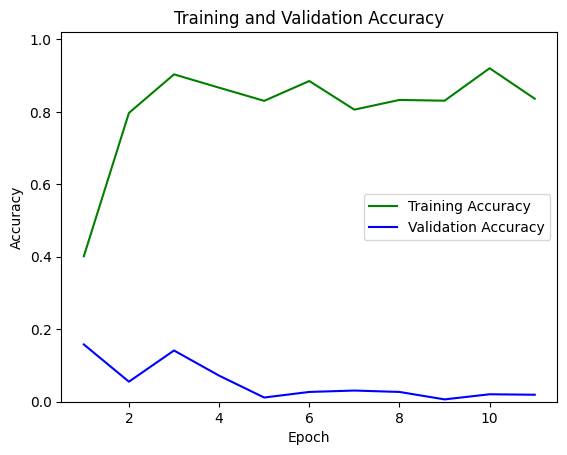

In [16]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,1.02)
plt.show()

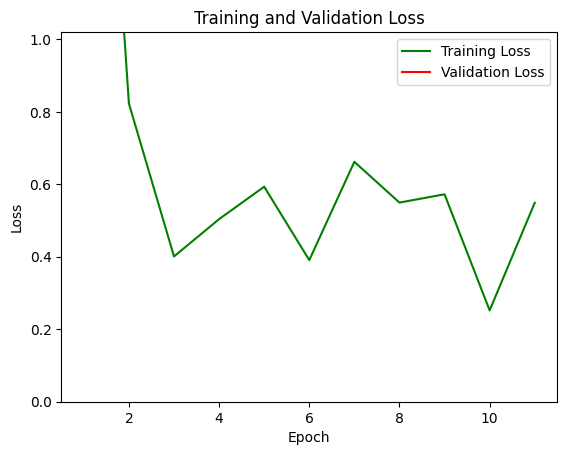

In [17]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

In [18]:
# Evaluate the model
model_evaluate = model_3.evaluate(x_train,y_train)
print("Loss     : ",model_evaluate[0])
print("Accuracy : ",model_evaluate[1])

86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.1972 - loss: 3.8751
Loss     :  3.8246703147888184
Accuracy :  0.19831068813800812


In [19]:
# Evaluate the model
model_evaluate = model_3.evaluate(x_val,y_val)
print("Loss     : ",model_evaluate[0])
print("Accuracy : ",model_evaluate[1])

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.1602 - loss: 3.8768
Loss     :  3.875523328781128
Accuracy :  0.15809768438339233


In [20]:
x_test=[]
y_test=[]


files=test_df['filename']

x_min=test_df['xmin']
x_max=test_df['xmax']
y_min=test_df['ymin']
y_max=test_df['ymax']

i=0

for filename in files:
    image=cv2.imread(os.path.join(test_dir,filename))
    cropped_image=image[y_min[i]:y_max[i],x_min[i]:x_max[i]]
    resized_image=cv2.resize(cropped_image,(224,224))
    rgb_image=cv2.cvtColor(resized_image,cv2.COLOR_BGR2RGB)
    x_test.append(rgb_image)
    i+=1

    
y_test=test_df['class']

In [21]:
for i in range(len(x_test)):
    x_test[i]=x_test[i]/255.0
    
y_test = label_encoder.transform(y_test)

In [22]:
x_test=np.array(x_test)
x_test= x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
y_test=np.array(y_test)

In [23]:
model_evaluate = model_3.evaluate(x_test,y_test)
print("Loss     : ",model_evaluate[0])
print("Accuracy : ",model_evaluate[1])

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 544ms/step - accuracy: 0.1794 - loss: 3.7870
Loss     :  3.7767233848571777
Accuracy :  0.17737789452075958


In [24]:
predictions = model_3.predict(x_test)
y_pred = predictions.argmax(axis=-1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 873ms/step


In [25]:
from sklearn.metrics import classification_report
print("Classification report : \n",classification_report(y_test, y_pred))

Classification report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         8
           2       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         7
           9       0.36      0.62      0.45         8
          10       0.00      0.00      0.00         5
          11       0.67      0.67      0.67         3
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         3
          15       0.25      0.50      0.33         2
          16       0.00      0.00      0.00         2
 